In [2]:
import pandas as pd
import sh
from collections import Counter
from nltk import word_tokenize
from nltk.tag import pos_tag
from string import punctuation
from pycountry import languages
from nltk.corpus import stopwords
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

I made the file below, etymwn-smaller.tsv, by running these unix commands: 

First, get only those entries with the relation "rel:etymology": 

```sh
    grep "rel:etymology" etymwn.tsv > etymwn-small.tsv 
```

Now we can remove the relation column, since it's all "rel:etymology": 

```sh
    cat etymwn-small.tsv | cut -f1,3 > etymwn-smaller.tsv
```

In [3]:
etymwn=pd.read_csv('etymwn-smaller.tsv', sep='\t')
etymwn.columns = ['word', 'parent']

In [4]:
etymwn

,word,parent
0,afr: Japan,nld: Japan
1,afr: Maandag,nld: maandag
2,afr: Maleis,nld: Maleis
3,afr: Pieter,nld: Pieter
4,afr: Woensdag,afr: woensdag
5,afr: aalmoes,nld: aalmoes
6,afr: aalmoesenier,nld: aalmoezenier
7,afr: aalwee,nld: aloë
8,afr: aambeeld,nld: aambeeld
9,afr: aambei,nld: aambei


In [106]:
class LangList():
    def __init__(self, langs): 
        self.langs = langs
            
    def __repr__(self): 
        return str(self.langs)
    
    @property
    def stats(self): 
        counter = Counter(self.langs)
        stats = {}
        for lang in counter.keys(): 
            stats[lang] = (counter[lang] / len(self.langs))*100 
        return stats

class Word(): 
    def __init__(self, word, lang='eng'): 
        self.lang = lang
        self.word = word
        
    def __repr__(self): 
        return '%s (%s)' % (self.word, self.lang)
    
    def __str__(self): 
        return self.word
        
    def oldVersions(self, language): 
        """
        Returns a list of older versions of a language, such that given "eng" (Modern English)
        it will return "enm" (Middle English). This is used for filtering out current languages
        in the ignoreSelf option of parents() below. 
        """
        if language == 'eng': 
            return ['enm']
        if language == 'fra': 
            return ['frm', 'xno'] # Middle French
        if language == 'dut':
            return ['dum'] # Middle Dutch
        if language == 'gle': # Irish
            return ['mga'] # Middle Irish 
        # TODO: add other languages here. 
        else: 
            return []
        
    @property
    def parents(self, ignoreAffixes=True, ignoreSelf=True):
        """ 
        ignoreAffixes will remove suffixes like -ly, so that the parent list for
        "universally" returns "universal (eng)" instead of "universal (eng), -ly (eng)." 
        
        ignoreSelf will ignore etymologies in the current language and slightly older versions of
        that language, so that it skips "universal (eng)," and goes straight to the good
        stuff, i.e. "universalis (lat)." Given a word in English, it will skip all other
        English and Middle English ancestors, but won't skip Old English. 
        """
        word = self.word
        language = self.lang
        
        # Finds the first-generation ancestor(s) of a word. 
        rawParentList = etymwn[etymwn['word']==language + ": " + word]['parent'].tolist()
        parentList = [self.split(parent) for parent in rawParentList] 
        if ignoreAffixes: 
            parentList = [p for p in parentList if p.word[0] is not '-']
            parentList = [p for p in parentList if p.word[-1] is not '-']
        if ignoreSelf: 
            newParents = [] 
            for parent in parentList: 
                if parent.lang == language or parent.lang in self.oldVersions(language): 
                    for otherParent in parent.parents: # Go deeper. 
                        newParents.append(otherParent)
                else: 
                    newParents.append(parent)
            parentList = newParents
        return parentList
    
    # TODO: foreignParents
    
    @property
    def parentLanguages(self):
        parentLangs = []
        for parent in self.parents: 
            parentLangs.append(parent.lang)
        return LangList(parentLangs)
    
    @property
    def grandparents(self): 
        return [Word(parent.word, lang=parent.lang).parents for parent in self.parents]
    
    @property
    def grandparentLanguages(self):
        grandparentLangs = []
        for grandparentList in self.grandparents: 
            for grandparent in grandparentList: 
                grandparentLangs.append(grandparent.lang)
        return LangList(grandparentLangs)
    
    def split(self, expression): 
        """ Takes and expression in the form 'enm: not' and returns 
        a Word object where word.lang is 'enm' and word.word is 'not'. 
        """
        parts = expression.split(':')
        return Word(parts[1].strip(), parts[0])

class Text():
    def __init__(self, text, lang='eng'): 
        self.text = text
        self.lang = lang
    
    @property
    def tokens(self): 
        return word_tokenize(self.text)
        
    @property
    def cleanTokens(self, removeStopwords=True): 
        clean = [token for token in self.tokens if token not in punctuation]
        clean = [token.lower() for token in clean]
        clean = [token for token in clean if token.isalpha()]
        if removeStopwords:
            clean = self.removeStopwords(clean)
        return clean
    
    def removeStopwords(self, tokens): 
        availableStopwords = "danish english french hungarian norwegian spanish "\
        "turkish dutch finnish german italian portuguese russian swedish".split()
        stopDict = {lang[:3]: lang for lang in availableStopwords}
        if self.lang in stopDict: 
            stops = stopwords.words(stopDict[self.lang])
            return [token for token in tokens if token not in stops]
        else: 
            return tokens

    @property
    def types(self): 
        return set(self.cleanTokens)
    
    @property
    def posTags(self):
        return pos_tag(self.types)
    
    @property
    def lemmas(self): 
        wordnetLemmatizer = WordNetLemmatizer()
        lemmas = []
        for word, pos in self.posTags:
            pos = self.get_wordnet_pos(pos)
            if pos == '': 
                pos = 'n'
            lemmas.append(wordnetLemmatizer.lemmatize(word, pos))
        return lemmas
    
    def get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return ''
        
    @property
    def wordObjects(self): 
        return [Word(token) for token in self.lemmas]
    
    def showMacroEtym(self): 
        for word in self.wordObjects: 
            print(word, word.parents)
    
    def getStats(self, pretty=False): 
        statsList = [word.parentLanguages.stats for word in self.wordObjects]
        stats = {}
        for item in statsList: 
            if len(item) > 0: 
                for lang, perc in item.items(): 
                    if lang not in stats: 
                        stats[lang] = perc
                    else: 
                        stats[lang] += perc
        allPercs = sum(stats.values())
        for lang, perc in stats.items(): 
            stats[lang] = ( perc / allPercs ) * 100
        
        if pretty:
            prettyStats = {}
            for lang, perc in stats.items(): 
                prettyLang = languages.get(iso639_3_code=lang).name
                prettyStats[prettyLang] = round(perc, 2) # rename the key
            return prettyStats
        else: 
            return stats

    langDict = {'Germanic': ['eng', 'enm', 'ang', 'deu', 'dut', 'non'],
                'Latinate': ['fra', 'frm', 'fro', 'lat'], 
                'Iranian': ['fas']}
    
    def getFamily(self, language): 
        for family, children in self.langDict.items(): 
            if language in children: 
                return family
        return 'Other'
    
    def getFamilyStats(self): 
        stats = self.getStats()
        families = {}
        for lang, perc in stats.items(): 
            fam = self.getFamily(lang)
            print(fam, lang, perc)
            if fam in families: 
                families[fam].append((lang, perc))
            else: 
                families[fam] = [(lang, perc)]
        return families
    
    def compileFamilyStats(self): 
        families = self.getFamilyStats()
        totals = {}
        for family, langs in families.items(): 
            totals[family] = 0
            for lang in langs: 
                totals[family] += lang[1]
        return totals
    
    @property
    def stats(self): 
        return self.getStats()
    
    def prettyStats(self): 
        return self.getStats(pretty=True)
    
    @property
    def familyStats(self): 
        return self.compileFamilyStats()

    def showPie(self):
        pd.Series(self.prettyStats()).plot(kind='pie', figsize=(6,6))

In [89]:
d = {'a', 'b', 'c'}
'b' in d

True

In [31]:
Word('universally').parentLanguages.familyStats

lat


In [32]:
Word('man').parentLanguages.stats

{'ang': 100.0}

In [8]:
Word('universally').parentLanguages.stats

{'lat': 100.0}

In [9]:
Word('admiration').parents

[admiration (fra)]

In [85]:
t = Text('It is a truth universally acknowledged, that a single man in possession of a good fortune,'\
         'must be in want of a wife.')
t.stats

{'ang': 37.03703703703704,
 'fas': 3.7037037037037033,
 'fro': 14.814814814814813,
 'lat': 33.33333333333333,
 'non': 11.11111111111111}

In [105]:
t = Text('It is a truth universally acknowledged, that a single man in possession of a good fortune,'\
         'must be in want of a wife.')
t.familyStats

Latinate fro 14.814814814814813
Iranian fas 3.7037037037037033
Germanic ang 37.03703703703704
Germanic non 11.11111111111111
Latinate lat 33.33333333333333


{'Germanic': 48.14814814814815,
 'Iranian': 3.7037037037037033,
 'Latinate': 48.14814814814814}

In [75]:
languages.get(iso639_3_code='fas').name

'Persian'

In [39]:
t = Text('"What is it that is magnificent?" and the count bent his eyes in various '\
         'directions in quest of the object of her admiration.')
t.prettyStats()

{'Anglo-Norman': 25.0,
 'French': 25.0,
 'French, Middle (ca. 1400-1600)': 25.0,
 'Latin': 25.0}

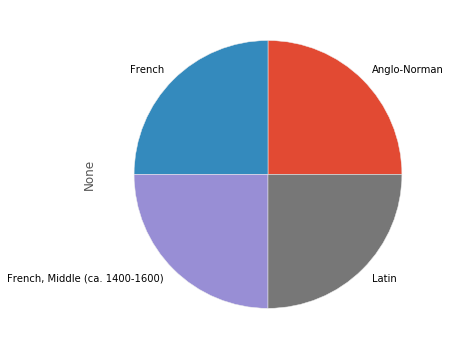

In [40]:
t.showPie()
# TODO: make colors prettier